In [62]:
import os
from ms2deepscore.utils import load_pickled_file
from matchms.importing.load_from_mgf import load_from_mgf
data_folder = "../../../data/pytorch/gnps_21_08_23_min_5_at_5_percent/trained_models/both_mode_precursor_mz_ionmode_2000_2000_2000_layers_500_embedding_2024_01_31_11_51_10/benchmarking_results/"
predictions = load_pickled_file(os.path.join(data_folder, "both_both_predictions.pickle"))
true_values = load_pickled_file(os.path.join(data_folder, "both_both_true_values.pickle"))

validation_spectra = list(load_from_mgf(os.path.join(data_folder, "../../../training_and_validation_split/positive_validation_spectra.mgf"))) + \
    list(load_from_mgf(os.path.join(data_folder, "../../../training_and_validation_split/negative_validation_spectra.mgf")))

## Benchmark exact match library searching

In [63]:
print(predictions.shape)
print(true_values.shape)
print(len(validation_spectra))


(11459, 11459)
(11459, 11459)
11459


In [54]:
import numpy as np
def select_one_spectrum_per_inchikey(spectra):
    inchikeys_per_spectrum = np.array([spectrum.get("inchikey")[:14] for spectrum in spectra])
    unique_inchikeys = np.unique(inchikeys_per_spectrum)
    # Loop through unique values and pick a random index for each
    random_indices = []
    for unique_inchikey in unique_inchikeys:
        spec_idx_matching_inchikey = np.where(inchikeys_per_spectrum == unique_inchikey)[0]
        random_index = np.random.choice(spec_idx_matching_inchikey)
        random_indices.append(random_index)
    one_spectrum_per_inchikey = np.array(random_indices)
    return one_spectrum_per_inchikey

In [69]:
import matplotlib.pyplot as plt

def find_correct_values(predictions, validation_spectra, indexes):
    scores = []
    correct = []
    for index in indexes: 
        predictions_for_query = predictions[:, index]
        # Set prediction to itself to 0
        predictions_for_query[index] = 0
        highest_score_index = np.argmax(predictions_for_query)
        highest_score = predictions_for_query[highest_score_index]
        
        found_inchikey = validation_spectra[highest_score_index].get("inchikey")[:14]
        correct_inchikey = validation_spectra[index].get("inchikey")[:14]
        scores.append(highest_score)
        correct.append(found_inchikey == correct_inchikey)
    correct = np.array(correct)
    scores =np.array(scores)
    return correct, scores
    
def plot_recall_accuracy(predictions, validation_spectra, nr_of_times):
    recalls = []
    true_positive_rates = []
    for _ in range(nr_of_times):
        indexes = select_one_spectrum_per_inchikey(validation_spectra)
        correct, scores = find_correct_values(predictions, validation_spectra, indexes)
        sorted_indices = np.argsort(scores)[::-1]
        sorted_correct = correct[sorted_indices]
        true_positive_rate = np.cumsum(sorted_correct)/np.arange(1, len(sorted_indices) + 1)
        recall = np.arange(1, len(sorted_indices) + 1)/len(sorted_indices)
        true_positive_rates.append(true_positive_rate)
    
    avg_accuracy = np.mean(true_positive_rates, axis=0)
    std_accuracy = np.std(true_positive_rates, axis=0)
    plt.fill_between(recall, avg_accuracy - std_accuracy, avg_accuracy + std_accuracy, alpha=0.3,
                     )
    plt.plot(recall, avg_accuracy)
    plt.xlabel('Recall')
    plt.ylabel('True Positive Rate')
    plt.ylim(0, 1.1)
    plt.xlim(0,1)


Text(0.5, 1.0, 'positive vs positive')

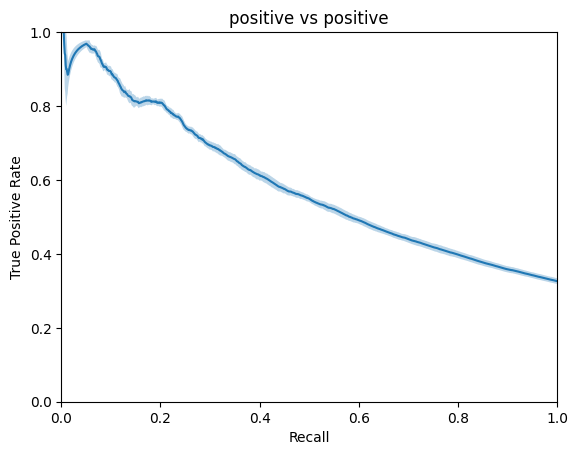

In [50]:
plot_recall_accuracy(predictions, validation_spectra, 10)
plt.title("positive vs positive")

Text(0.5, 1.0, 'negative vs negative')

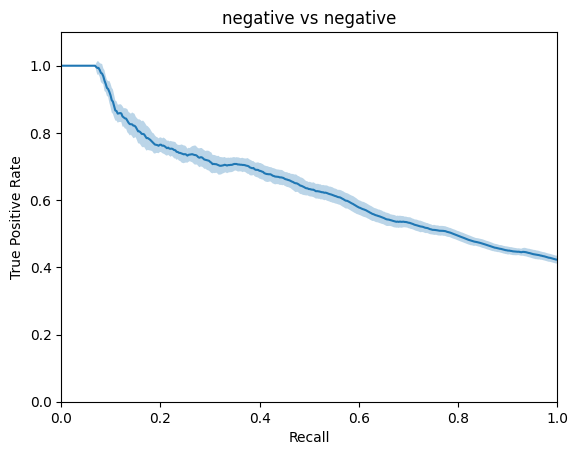

In [60]:
plot_recall_accuracy(predictions, validation_spectra, 10)
plt.title("negative vs negative")

Text(0.5, 1.0, 'both vs both')

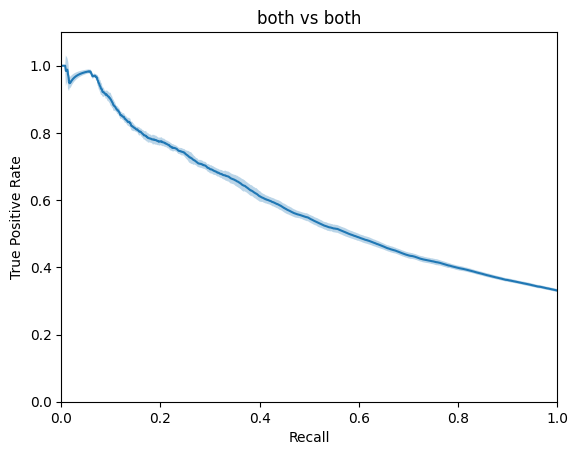

In [70]:
plot_recall_accuracy(predictions, validation_spectra, 10)
plt.title("both vs both")

## Code for creating roc_curve, not sure if yet fully functional

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def create_roc_curve(predictions: np.array,
                     true_values: np.array,
                     correct_match_cut_off,
                     steps=1000):
    flattened_true_values = true_values.flatten()
    flattend_predictions = predictions.flatten()
    flattened_true_values[flattened_true_values >= correct_match_cut_off] = 1
    flattened_true_values[flattened_true_values < correct_match_cut_off] = 0

    sorted_indices = np.argsort(flattend_predictions)[::-1]
    total_of_true_positives = np.sum(flattened_true_values)
    total_of_false_positives = len(flattened_true_values) - total_of_true_positives
    true_positive = []
    false_positive = []
    for step in range(0, len(flattened_true_values), len(flattened_true_values)//steps):
        selected_indices = sorted_indices[:step]
        true_positive.append(np.sum(flattened_true_values[selected_indices])/total_of_true_positives)
        false_positive.append(np.sum(1-flattened_true_values[selected_indices])/total_of_false_positives)
    # Plot the ROC-like curve
    plt.plot(false_positive, true_positive, label=f'> tanimoto {correct_match_cut_off}')


def create_recall_accuracy_plot(predictions: np.array,
                                true_values: np.array,
                                correct_match_cut_off,):
    flattened_true_values = true_values.flatten()
    flattend_predictions = predictions.flatten()
    flattened_true_values[flattened_true_values >= correct_match_cut_off] = 1
    flattened_true_values[flattened_true_values < correct_match_cut_off] = 0

    sorted_indices = np.argsort(flattend_predictions)[::-1]

    sorted_true_values = flattened_true_values[sorted_indices]

    total_of_true_positives = np.sum(flattened_true_values)
    true_positive_rate = np.cumsum(sorted_true_values)/np.arange(1, len(sorted_true_values) + 1)
    recall = np.cumsum(sorted_true_values)/total_of_true_positives

    plt.plot(recall, true_positive_rate, label=f'> tanimoto {correct_match_cut_off}')
    # plt.xlabel('Recall')
    # plt.ylabel('True Positive Rate')
    # plt.legend()
    # plt.show()


def create_multiple_recall_accuracy(predictions: np.array,
                     true_values: np.array,
                     match_cut_offs):
    for cut_off in match_cut_offs:
        create_recall_accuracy_plot(predictions,
                         true_values,
                         cut_off,
                         )
    plt.xlabel('Recall')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()



